In [1]:
#hidden cell to be executed BEFORE the presentation
import warnings
warnings.filterwarnings('ignore')
import sys
path = './dftpy/src' # If DFTpy is not in PYTHONPATH, change it to the path of where dftpy/src is located.
if path not in sys.path:
    sys.path.insert(0, path)
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from IPython.lib.display import YouTubeVideo
file1='Al_lda.oe01.recpot'
PP_list = {'Al': './dftpy/examples/DATA/'+file1}

In [2]:
#hidden cell to be executed BEFORE the presentation
from ase_notebook import AseView, ViewConfig
config = ViewConfig()
ase_view = AseView(config)
ase_view = AseView(
    rotations="45x,45y,45z",
    atom_font_size=16,
    axes_length=30,
    canvas_size=(700, 300),
    zoom=1.2,
    show_bonds=True
)
ase_view.config.uc_dash_pattern=(.6,.4)
#ase_view.add_miller_plane(
#    1, 0, 0, color="green")
ase_view.config
ase_view.config.canvas_color_background = "blue"
ase_view.config.canvas_background_opacity = 0.2

def view (ions):
    gui = ase_view.make_render(
    ions, center_in_uc=True)
    return gui
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
gui=view(ions)
gui
print('Done with preambles')

Done with preambles


<center>
    <h1>DFT and DFT embedding</h1>
    <h3> Ways to approach the mesoscopic world with ab-initio methods (without cutting corners)</h3>
<center>
<br>
<table>
  <tr>
      <td><p><h1>Michele Pavanello</h1></p><p><h2>Rutgers University-Newark</h2></p></td>
      <td><img src="figures/logos/run.png" width=200 height=200 /></td>
  </tr>
  <tr>
    <td></td>
    <td> http://prg.rutgers.edu</td>
  </tr>
</table>

#### LLNL Computational Chemistry & Materials Science Summer Institute -- July 25, 2022


# Acknowledgements

<table>
  <tr>
      <td><p><h3>Students</h3></p><p>Dr Xuecheng Shao</p><p>Dr Kaili Jiang</p><p>Dr Musa Khan</p><p>Jessica Martinez</p><p>Andres Cifuentes</p><p>Valeria Rios (incoming)</p><p>Jared Balski</p><p>2 HS students</p></td>
      <td><img src="figures/prg_pics/prg_2021.png" width=800 /></td>
  </tr>
</table>

Funding: NSF, DOE, MolSSI, ACS-PRF, Rutgers

# The Real World
<table>
    <tr>
      <td><h3>Photocatalyst</h3></td>
        <td><h3>Catalytic nanoparticles</h3></td>
  </tr>
  <tr>
      <td><img src="figures/science/photocatalyst.png" height=500 /></td>
      <td><img src="figures/science/catalyst.png" height=500 /></td>
  </tr>
    <tr>
        <td>Chem. Comm., 43, 6551 (2009)</td>
        <td>PCCP, 21, 15080 (2019)</td>
    </tr>
</table>   

# Available electronic structure methods
<br>
<center>
    <img src="figures/science/electronic_structure.png" width=1600 />
</center>

# Poll time

Let's check your DFT knowledge. 

- What is Kohn-Sham DFT's energy density functional?
- Please write your answer somewhere. 
- Be ready to discuss it with others or with the class.

# An option: Orbital-free DFT (OF-DFT)
<br>

<center>
<ul>
    <li><p>The variational function is the electron density <u>only</u></p> 
        <p>$$n(\mathbf{r})=N \Psi(\mathbf{r})$$</p></li>
    <li><p>The energy functional is a pure functional of $n(\mathbf{r})$</p>
        <p>$$E[n]=T_s[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r} + E_{Hxc}[n]$$</p></li>
    <li><p>Ground state is found by direct minimization</p>
        <p>$$n_0(\mathbf{r})=\text{argmin}_n\left[ E[n]-\mu \left(\int n(\mathbf{r})d\mathbf{r}-N\right)\right]$$</p></li>
</ul>
</center>
<table>
    <tr>
        <td><div class="alert alert-block alert-success"><center><b>Opportunity:</b> No need to diagonalize any matrix!</center></div></td>
        <td><div class="alert alert-block alert-danger"><center><b>Problem:</b> $T_s[n]$ exists, but it is not known...</center></div></td>
    </tr>
</table>




# How hard is it to run OF-DFT simulations?

### First generate a model system: bulk Al (cubic cell)

In [3]:
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
view(ions)

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(aspect=2.3333333333333335, fov=10.0, position=(0.0,…

### Then run a OF-DFT simulation with `DFTpy`

In [4]:
nr = ecut2nr(ecut=35, lattice=ions.cell)
grid = DirectGrid(lattice=ions.cell, nr=nr)
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume
HARTREE = Functional(type='HARTREE')
XC = Functional(type='XC',name='LDA')

setting key: Al -> ./dftpy/examples/DATA/Al_lda.oe01.recpot


- $T_s[n]$ also called KEDF. In this example we use Thomas Fermi + von Weizsacker:
$$T_s[n] = \int C_{TF} n^{5/3}(\mathbf{r}) + \frac{\nabla n^{1/2}(\mathbf{r})\cdot \nabla n^{1/2}(\mathbf{r})}{2} d\mathbf{r}$$

In [5]:
KE = Functional(type='KEDF',name='x_TF_y_vW') 

### Define "total energy" and minimize $E[n]$

In [6]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
optimization_options = {'econv' : 1e-3*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options,
        optimization_method = 'TN')
%timeit -n1 -r2 rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       4.027605E-03    
1       2.509905170128E+00      -1.822483E-01   7.033209E-02    2       1       9.629726E-03    
2       2.502273081619E+00      -7.632089E-03   4.803550E-03    7       1       1.962924E-02    
3       2.502030159462E+00      -2.429222E-04   3.640551E-04    5       1       2.735496E-02    
4       2.501995243587E+00      -3.491588E-05   3.590733E-05    6       1       3.616929E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.30114593945068535
Chemical potential (eV)  : 8.194597626151099
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       1.482248E-03    
1       2.509905170128E+00      -1.822483E-01   7.033209E-02    2       1       5.736589E-0

...let's try to re-run it with a different $T_s[n]$.

### Re-run of OF-DFT with nonlocal $T_s[n]$

In [7]:
KE = Functional(type='KEDF',name='LMGP')
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
optimization_options = {'econv' : 1e-3*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options,
        optimization_method = 'TN')
%timeit -n1 -r2 rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       2.970146E+00    
1       2.463032297815E+00      -2.291212E-01   1.146670E-01    2       2       2.995292E+00    
2       2.442251262505E+00      -2.078104E-02   1.111830E-02    8       1       3.127903E+00    
3       2.440940642139E+00      -1.310620E-03   7.871782E-04    8       1       3.263182E+00    
4       2.440753707588E+00      -1.869346E-04   4.651637E-05    10      1       3.428499E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.29296043119271786
Chemical potential (eV)  : 7.971858622391213
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       2.356768E-03    
1       2.463029269220E+00      -2.291242E-01   1.151135E-01    2       2       3.774285E-0

<center><div class="alert alert-block alert-danger">
    Nonlocal $T_s[n]$ are one order of magnitude slower than semilocal functionals
</div> 
    </center>

# How does OF-DFT compare with KS-DFT?

<h4 style="text-align: center;">We will run a Quantum ESPRESSO calculation of the same system using QEpy</h4>

In [8]:
from qepy.driver import Driver

In [9]:
driver=Driver('qe_in.in', comm=None, logfile='qepy.out')
%timeit -n1 -r1 driver.scf()

54.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
driver.get_scf_error()

8.313111632513005e-07

In [11]:
driver.stop()

<center><div class="alert alert-block alert-danger">
    sDFT is one$+$ order of magnitude slower than nonlocal OF-DFT!
</div></center>

### $T_s[n]$: (semi)local and nonlocal functionals
<br>
<center>
    <img src="figures/science/local_nonlocal.png" width=1600 />
<p>Wenhui Mi, MP JCP (2018) • Wenhui Mi, MP PRB (2019) • Xuecheng Shao, WM, MP PRB (2021)
Xuecheng Shao, WM, MP JPCL (2021) • Xuecheng Shao, WM, MP JCTC (2021) • Wenhui Mi, MP JPCL (2020)</p>
    </center>

# Poll time
- People say OF-DFT is a "linear-scaling method". Do you agree?

<div class="alert alert-block alert-success">
<b>A:</b> Yep! I do!</div>

<div class="alert alert-block alert-danger">
<b>B:</b> Nah. Not really.</div>


# Can OF-DFT approach surfaces?

<center>
    <p style="font-size:100%; text-align:center;">Shao, Mi & Pavanello, Phys. Rev. B <b>104</b>, 045118 (2021)</p>
    <br>
    <img src="figures/science/ofdft_surfaces.png" width=1800 />
    <div class="alert alert-block alert-success">Excellent results for difficult semiconductors and metals!</div>
</center>

# What else can OF-DFT do?
<br>
<center>
    <p style="font-size:100%; text-align:center;"> J. Phys. Chem. Lett. <b>12</b>, 4134 (2021) &#x25C6; WIREs: Comp. Mol. Sci. <b>11</b>, e1482 (2021)</p>
    <br>
    <img src="figures/science/ofdft_showoff.png" width=1600 />
    <div class="alert alert-block alert-danger">How about optical spectra and dynamics?</div>
</center>

# OF-DFT is limited...
<br>
<center>
<img src="figures/science/periodic_all.png" width=1100 />
</center>

# OF-DFT is limited...
<br>
<center>
<img src="figures/science/periodic_ofdft.png" width=1100 />
</center>

# Poll time
- How would you fix this problem?

<div class="alert alert-block alert-warning">
<b>A:</b> Use KS-DFT for atoms only, or smaller fragments of the system</div>

<div class="alert alert-block alert-warning">
<b>B:</b> Throw OF-DFT away!</div>

<div class="alert alert-block alert-warning">
<b>C:</b> Introduce nonlocal pseudopotentials in OF-DFT</div>


# Subsystem DFT (sDFT) - Theory

<div class="alert alert-block alert-warning">
    <p><b>Idea:</b></p>
    <ul>
        <li>Split system into (smaller) subsystems: $n(\mathbf{r})=\sum_I n_I(\mathbf{r})$</li>
        <li>Use KS-DFT <b>or</b> OF-DFT for the subsystems</li>
        <li><p>Energy is split in <i>additive</i> and <i>non-additive</i> terms:</p><p>$$E[n]\equiv E[\{n_I\}]=\sum_I E[n_I] + E^{nadd}[\{n_I\}]$$</p></li>
        <li><p>The nonadditive energy given by:</p><p>$$E^{nadd}[\{n_I\}] = E[n] - \sum_IE[n_I] \to \tilde T_s^{nadd}[\{n_I\}]+E_{Hxc}^{nadd}[\{n_I\}]$$</p></li>
    </ul>
</div>
<div class="alert alert-block alert-danger">
<b>Problem:</b> The non-additive energy contains the non-additive kinetic energy, $T_s^{nadd}[\{n_I\}]$, which not known.
</div>
<div class="alert alert-block alert-success">
    <b>Opportunity:</b> We can use <i>fancy non-local</i> $T_s^{nadd}[\{n_I\}]$, previously developed for OF-DFT.
</div>

# Subsystem DFT (sDFT) - Claim to fame!
<center>
<img src="figures/science/eqe_cover.png" width=600 />
</center>

# Subsystem DFT (sDFT) - Timings
<br>
<center>
<img src="figures/science/sdft_timings.png" width=1300 />
</center>
<ul>
    <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
    <li> Int. J. Quantum Chem. <b>117</b> e25401 (2017)</li>
    <li> J. Phys. Chem. Lett. <b>10</b> 7554 (2019)</li>
</ul>


# How accurate is sDFT?
<br>

<p style="font-size:100%; text-align:center;">Deviation against CCSD(T) for the S66 test set</p>

<table>
    <tr>
        <td>
            <center>
                <img src="figures/science/sdft_s66.png" width=700 />
            </center>
        </td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>
            <center>
                <img src="figures/science/s66_other_methods.jpeg" width=700 />
            </center>
        </td>
    </tr>
    <tr>
        <td>
            <ul>
                <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
                <li> J. Chem. Theory Comput. <b>17</b> 3455 (2021)</li>
                <li> J. Phys. Chem. Lett. <b>11</b> 272 (2020)</li>
            </ul>
        </td>
        <td>
        </td>
        <td>
            <ul>
                <li> J. Chem. Theory Comput. <b>7</b> 2427 (2011)</li>
            </ul>
        </td>
    </tr>
    </tr>
</table>


# sDFT is not perfect either...
<p>The nonadditive kinetic energy, $T_s^{nadd}[n]$, is not accurate enough when...</p>
<br>
<table>
    <tr>
    <td> &#x25C6; ...there are covalent bonds between subsystems</td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td> &#x25C6; ...subsystems are too close</td>
    </tr>
</table>
<br>
<center>
    <img src="figures/science/sdft_adaptive.png" width=950 />
    <p style="color: red; font-size:90%; text-align:center;">We need an "adaptive" sDFT method!</p>
</center>


# Adaptive sDFT

<br>

#### To do:

<ul style="text-align: left; font-size: 70%; line-height:90%;margin-top: 0; margin-bottom: 0;">
    <li>Must be able to "split" and "merge" subsystems along a dynamics</li>
    <li>Do so <i>automatically</i></li>
</ul>

<br>
<br>

<h4 style="margin-top: 0.5em;"> We did it... but it was challenging</h4>
<table>
    <tr>
        <td>
            <center>
            <ul style="border:2px solid red; text-align: left; font-size: 135%; line-height:150%; margin-right: 1em;">
                <li>Adaptive computational settings</li>
                <li>Adaptive MPI communicators</li>
                <li>Adaptive data allocation</li>
            </ul>
            </center>
        </td>
        <td style="width:55%">
            <img src="figures/science/sdft_merging_cells.png" width=100% />
        </td>
    </tr>
</table>

# Adaptive sDFT

https://www.youtube.com/watch?v=-lmdPHzJfeU

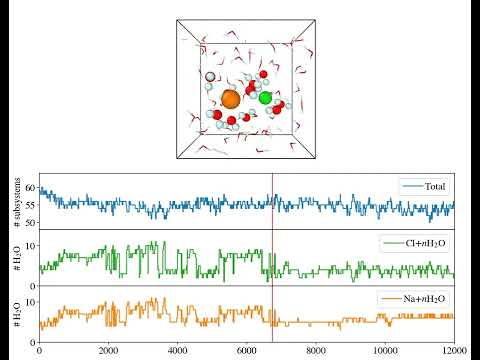

In [15]:
YouTubeVideo('-lmdPHzJfeU', width=600, height=450)

# What did you (hopefully) learn?

<hr>
<div class="alert alert-block alert-success">
    <b>Good things:</b><br>
    <ul>
        <li> OF-DFT is very fast and linear scaling with system size</li>
        <li> OF-DFT is useful for metals and semiconductors of any shape and size</li>
        <li> Where OF-DFT fails we can use Subsystem DFT. Still linear scaling!</li>
        <li> Therefore, KS-DFT can be completely avoided</li>
    </ul>
</div>

<hr>

<div class="alert alert-block alert-danger">
<b>Bad things:</b><br>
    <ul>
        <li> OF-DFT has limited applicability because of the "nonlocal pseudopotential problem"</li>
        <li> Subsystem DFT is fast but only if subsystems are small</li>
    </ul>
</div>
<hr>

# Thank you!

## Cheat Sheet

- https://www.ibm.com/docs/en/db2-event-store/2.0.0?topic=notebooks-markdown-jupyter-cheatsheet